SYLOGISM TRAINING USING GRPO --- LOG SAVED IN wordle_log.txt

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import LoraConfig, get_peft_model
import torch

ckpt = "Qwen/Qwen2.5-7B-Instruct"

# Load the base model
model = AutoModelForCausalLM.from_pretrained(
    ckpt, device_map="auto", torch_dtype=torch.bfloat16, attn_implementation="eager"
)

# LoRA configuration
lora_config = LoraConfig(
    task_type="CAUSAL_LM",  # Important: specify causal language modeling task
    r=16,
    lora_alpha=32,
    target_modules="all-linear",  # or specify the exact modules to apply LoRA to
)

# Apply LoRA to the model
model = get_peft_model(model, lora_config)

print(model.print_trainable_parameters())

# Load tokenizer (no processor here)
tokenizer = AutoTokenizer.from_pretrained(ckpt)


Loading checkpoint shards: 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]


trainable params: 40,370,176 || all params: 7,655,986,688 || trainable%: 0.5273
None


In [4]:
import re
from datasets import load_dataset, Dataset

SYSTEM_PROMPT = """
You are playing Wordle, a word-guessing game.

### Game Rules:
- You have 6 tries to guess a secret 5-letter English word.
- After each guess, you will receive feedback on each letter using these symbols:
  ✓ : The letter IS IN THE WORD and in the CORRECT position.
  - : The letter is IN THE WORD but in the WRONG position.
  x : The letter is NOT in the word.

### Required Output Format:
YOU **MUST** respond **only** in the following format:

<think>
Step-by-step logical reasoning based on the feedback from previous guesses.
</think>
<guess>
your-5-letter-word
</guess>

**CRUCIAL:**  
- The <guess> tag MUST come AFTER the CLOSED </think> tag.Any response where <guess> appears before </think> is invalid and will be discarded.   
- You **MUST** include the `<guess>` tag after the reasoning, with your guessed word inside.  
- DO NOT write anything outside these tags.  
- Your guessed word must be exactly 5 letters, lowercase, and consistent with the feedback.

### Example:

Here is an example of the expected response format.

Previous Feedback:
Guess 1: CRANE → Feedback: C(✓) R(x) A(✓) N(x) E(x)  
Guess 2: COAST → Feedback: C(✓) O(-) A(✓) S(-) T(x)

<think>
1. From Guess 1, C is correct in position 1, A is correct in position 3.
2. R, N, E are not in the word at all.
3. From Guess 2, O and S are in the word, but not in positions 2 or 4.
4. T is not in the word.
5. So the word must have C at position 1, A at position 3, O and S somewhere (not positions 2 and 4), and cannot include R, N, E, or T.
6. A possible valid word is COALS.
</think>
<guess>
coals
</guess>

### IMPORTANT:
You must ALWAYS close the `<think>` tag. Missing it means your response is invalid.

### Valid Format Example:
Previous Feedback:
Guess 1: LATCH → Feedback: L(x) A(✓) T(-) C(x) H(x)

<think>
1. A is correct in position 2.
2. T is in the word but not in position 3.
3. L, C, H are not in the word.
</think>
<guess>
satin
</guess>

### Invalid Format Example (Missing closing </think> tag):

<think>
1. A is in position 2.
2. T is somewhere else.
<guess>
satin
</guess> ← ❌ INVALID — missing </think> tag!

### Invalid Format Example (guess before think):

<guess>
satin
</guess>
<think>
This guess was based on prior logic...
</think> ← ❌ INVALID — <think> must come before <guess>

"""

XML_COT_FORMAT = """\
<reasoning>
{reasoning}
</reasoning>
<answer>
{answer}
</answer>
"""

def extract_xml_answer(text: str) -> str:
    match = re.search(r"<guess>\s*(.*?)\s*</guess>", text, re.IGNORECASE | re.DOTALL)
    if match:
        word = match.group(1).strip()
        return word.lower() if len(word) == 5 and word.isalpha() else ""
    return ""



def extract_hash_answer(text: str) -> str | None:
    if "####" not in text:
        return None
    return text.split("####")[1].strip()


def get_wordle_dataset(split="train") -> Dataset:
    data = load_dataset("predibase/wordle-grpo", split=split)
    
    # Prepare the prompt-answer pairs
    data = data.map(lambda x: {
        'prompt': [
            {'role': 'system', 'content': SYSTEM_PROMPT},
            {'role': 'user', 'content': x['prompt']}  # Use the full prompt from the dataset
        ],
        'answer': x['secret']  # secret word as the final answer to guess
    })
    return data

dataset = get_wordle_dataset()

In [5]:
import pprint
import string

epoch_rewards = []
epoch_losses = []
epoch_advantages = []
format_reward_log = []
correctness_reward_log = []
xmlcount_reward_func_log = []

def normalize(s):
    return s.lower().strip().translate(str.maketrans('', '', string.punctuation))

def correctness_reward_func(prompts, completions, answer, **kwargs) -> list[float]:
    responses = [completion[0]['content'] for completion in completions]
    q = prompts[0][-1]['content']
    extracted_guesses = [extract_xml_answer(r) for r in responses]

    reward_values = []
    for guess, ans in zip(extracted_guesses, answer):
        norm_guess = normalize(guess) if guess else ""
        norm_ans = normalize(ans) if ans else ""
        # print("-"*20)
        # print(f"Normalized Guess: {norm_guess}, Normalized Answer: {norm_ans}")
        reward = 2.0 if norm_guess == norm_ans else 0.0
        reward_values.append(reward)

    avg_reward = sum(reward_values) / len(reward_values)
    correctness_reward_log.append(avg_reward)
    epoch_rewards.append(avg_reward)

    print("-"*20)
    print(f"Prompt:\n{q}")
    print("-"*20)
    print(f"Response:\n{responses[0]}")
    print("-"*20)
    print(f"Extracted Guess:\n{extracted_guesses[0]}")
    print("-"*20)
    print(f"Answer:\n{answer[0]}")
    # print("-"*20)
    # print(f"Correctness Reward: {reward_values}")
    return reward_values


strict_format_reward_log = []
def strict_format_reward_func(completions, **kwargs) -> list[float]:
    """Checks strict format: <think> ... </think>\n<guess> ... </guess>"""
    pattern = r".*?</think>\s*<guess>.*?</guess>"
    responses = [completion[0]['content'] for completion in completions]
    matches = [re.match(pattern, r, re.DOTALL) for r in responses]
    # print("-"*50)
    # print("strict_format_reward_func",matches)
    # print("-"*50)
    return [0.5 if match else 0.0 for match in matches]

def soft_format_reward_func(completions, **kwargs) -> list[float]:
    """Checks that both <think> and <guess> tags appear somewhere"""
    pattern = r".*?</think>\s*<guess>.*?</guess>"
    responses = [completion[0]['content'] for completion in completions]
    matches = [re.search(pattern, r, re.DOTALL) for r in responses]
    # print("-"*50)
    # print("soft_format_reward_func",matches)
    # print("-"*50)
    return [0.5 if match else 0.0 for match in matches]

def count_xml(text: str) -> float:
    count = 0.0

    # Normalize whitespace
    cleaned = text.strip()

    # Count <think> and </think>
    if re.search(r"<think>\s*", cleaned):
        count += 0.125
    if re.search(r"</think>", cleaned):
        count += 0.125

    # Count <guess> and </guess>
    if re.search(r"<guess>\s*", cleaned):
        count += 0.125

        # Penalize for text after </guess>
        parts = re.split(r"</guess>", cleaned)
        if len(parts) > 1:
            after = parts[1].strip()
            count -= len(after) * 0.001

    if re.search(r"</guess>", cleaned):
        count += 0.125

        # Extra penalty for characters after </guess> (again, just in case)
        parts = re.split(r"</guess>", cleaned)
        if len(parts) > 1:
            after = parts[1].strip()
            count -= max(len(after) - 1, 0) * 0.001

    return count

def xmlcount_reward_func(completions, **kwargs) -> list[float]:
    rewards = []  # Empty list to store rewards
    contents = [completion[0]['content'] for completion in completions]
    reward_values = []
    for c in contents:
        reward = count_xml(c)  # Compute reward using count_xml
        # print("-"*50)
        # print(f"Content: {c}\nReward: {reward}\n")  # Print content and reward
        # print("-"*50)
        reward_values.append(reward)  # Store the reward in the list

    avg_reward = sum(reward_values) / len(reward_values)
    epoch_rewards.append(avg_reward)
    xmlcount_reward_func_log.append(avg_reward)

    return reward_values


In [22]:
import os
os.makedirs("./logs_test", exist_ok=True)
print("Folder created")


Folder created


In [23]:
from transformers import Trainer, TrainingArguments
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from datasets import load_dataset

model_name = "distilbert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

dataset = load_dataset("glue", "sst2", split="train[:1%]")
def tokenize(batch):
    return tokenizer(batch["sentence"], padding=True, truncation=True)

dataset = dataset.map(tokenize, batched=True)
dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

training_args = TrainingArguments(
    output_dir="./results",
    logging_dir="./logs",
    logging_steps=5,
    report_to="tensorboard",
    num_train_epochs=1,
    per_device_train_batch_size=8,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
)

trainer.train()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 673/673 [00:00<00:00, 29616.07 examples/s]


Step,Training Loss
5,0.649700
10,0.810500
15,0.682400
20,0.631900
25,0.655700
30,0.564800
35,0.560700
40,0.508900
45,0.407300
50,0.441000


TrainOutput(global_step=85, training_loss=0.5056504193474265, metrics={'train_runtime': 2.8766, 'train_samples_per_second': 233.959, 'train_steps_per_second': 29.549, 'total_flos': 9750842422944.0, 'train_loss': 0.5056504193474265, 'epoch': 1.0})

In [6]:
from trl import GRPOConfig, GRPOTrainer

max_prompt_length = 256
max_seq_length = 1024

from transformers import TrainingArguments

training_args = GRPOConfig(
    learning_rate = 5e-6,
    adam_beta1 = 0.9,
    output_dir="./results",
    logging_dir="./logs",  
    adam_beta2 = 0.99,
    weight_decay = 0.1,
    warmup_ratio = 0.1,
    lr_scheduler_type = "cosine",
    optim = "adamw_8bit",
    logging_steps = 1,
    per_device_train_batch_size = 2,
    gradient_accumulation_steps = 1,
    num_generations = 2,
    max_prompt_length = max_prompt_length,
    max_completion_length = max_seq_length - max_prompt_length,
    num_train_epochs = 3,
    max_steps= 4,       
    save_steps = 100,       
    max_grad_norm = 0.1,
    report_to = "tensorboard",
)

#max_steps= 10, 

INFO 09-11 16:13:13 [__init__.py:241] Automatically detected platform cuda.


In [7]:
trainer = GRPOTrainer(
    model=model,
    processing_class=tokenizer,
    reward_funcs=[
        xmlcount_reward_func,
        soft_format_reward_func,
        strict_format_reward_func,
        correctness_reward_func,
    ],
    args=training_args,
    train_dataset=dataset,
)

result = trainer.train()
print("valllllllllll is : ",result)

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.


--------------------
Prompt:
<|im_start|>system

You are playing Wordle, a word-guessing game.

### Game Rules:
- You have **6 tries** to guess a secret **5-letter** word.
- Each guess must be a valid **5-letter English word**.
- After each guess, you will receive feedback indicating how close your guess was.

### Feedback Format:
Each letter in your guess will receive one of three symbols:
1. ✓ : The letter is in the word and in the CORRECT position.
2. - : The letter is in the word but in the WRONG position.
3. x : The letter is NOT in the word.

### Example:
Secret Word: BRISK

Guess 1: STORM → Feedback: S(-) T(x) O(x) R(-) M(x)
Guess 2: BRAVE → Feedback: B(✓) R(✓) A(x) V(x) E(x)
Guess 3: BRISK → Feedback: B(✓) R(✓) I(✓) S(✓) K(✓)

### Response Format:
Think through the problem and feedback step by step. Make sure to first add your step by step thought process within <think> </think> tags. Then, return your guessed word in the following format: <guess> guessed-word </guess>.
<|im_en

Step,Training Loss
1,0.046000
2,0.012100
3,0.133200
4,-0.018000


--------------------
Prompt:
<|im_start|>system

You are playing Wordle, a word-guessing game.

### Game Rules:
- You have **6 tries** to guess a secret **5-letter** word.
- Each guess must be a valid **5-letter English word**.
- After each guess, you will receive feedback indicating how close your guess was.

### Feedback Format:
Each letter in your guess will receive one of three symbols:
1. ✓ : The letter is in the word and in the CORRECT position.
2. - : The letter is in the word but in the WRONG position.
3. x : The letter is NOT in the word.

### Example:
Secret Word: BRISK

Guess 1: STORM → Feedback: S(-) T(x) O(x) R(-) M(x)
Guess 2: BRAVE → Feedback: B(✓) R(✓) A(x) V(x) E(x)
Guess 3: BRISK → Feedback: B(✓) R(✓) I(✓) S(✓) K(✓)

### Response Format:
Think through the problem and feedback step by step. Make sure to first add your step by step thought process within <think> </think> tags. Then, return your guessed word in the following format: <guess> guessed-word </guess>.
<|im_en

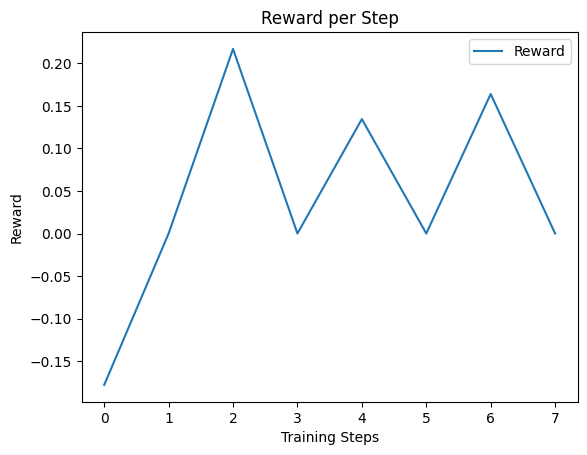

In [8]:
import matplotlib.pyplot as plt

# Simple plot after training
plt.plot(epoch_rewards, label="Reward")
plt.xlabel("Training Steps")
plt.ylabel("Reward")
plt.title("Reward per Step")
plt.legend()
plt.show()


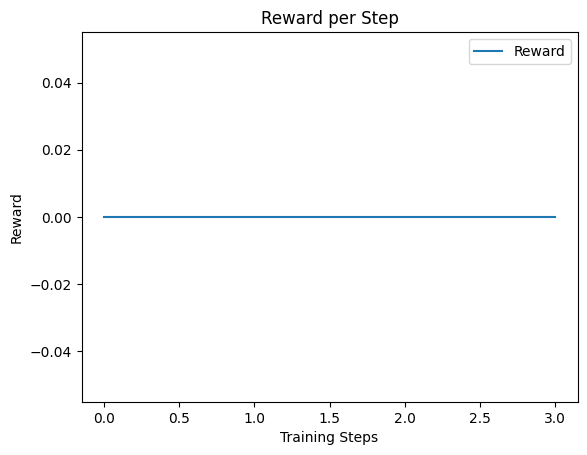

In [9]:
import matplotlib.pyplot as plt

# Simple plot after training
plt.plot(correctness_reward_log, label="Reward")
plt.xlabel("Training Steps")
plt.ylabel("Reward")
plt.title("Reward per Step")
plt.legend()
plt.show()


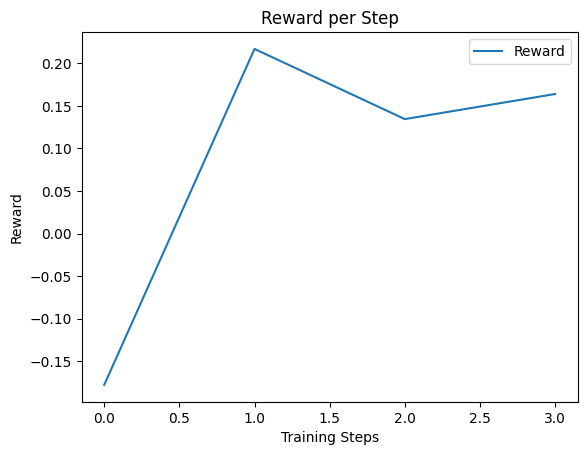

In [10]:
import matplotlib.pyplot as plt

# Simple plot after training
plt.plot(xmlcount_reward_func_log, label="Reward")
plt.xlabel("Training Steps")
plt.ylabel("Reward")
plt.title("Reward per Step")
plt.legend()
plt.show()


In [ ]:
# import torch
# from transformers import AutoProcessor, AutoModelForImageTextToText
# from peft import LoraConfig, get_peft_model
# #ckpt = "google/gemma-3-4b-it"
# ckpt = "Qwen/Qwen2.5-7B-Instruct"

# model = AutoModelForImageTextToText.from_pretrained(
#     ckpt, device_map="auto", torch_dtype=torch.bfloat16, attn_implementation="eager"
# )

# # Load LoRA
# lora_config = LoraConfig(
#     task_type="CAUSAL_LM",
#     r=16,
#     lora_alpha=32,
#     target_modules="all-linear",
# )
# model = get_peft_model(model, lora_config)
# print(model.print_trainable_parameters())

# processor = AutoProcessor.from_pretrained(ckpt)

/home/athenaik/GRPO_test/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
`torch_dtype` is deprecated! Use `dtype` instead!


ValueError: Unrecognized configuration class <class 'transformers.models.qwen2.configuration_qwen2.Qwen2Config'> for this kind of AutoModel: AutoModelForImageTextToText.
Model type should be one of AriaConfig, AyaVisionConfig, BlipConfig, Blip2Config, ChameleonConfig, Cohere2VisionConfig, DeepseekVLConfig, DeepseekVLHybridConfig, Emu3Config, EvollaConfig, Florence2Config, FuyuConfig, Gemma3Config, Gemma3nConfig, GitConfig, Glm4vConfig, Glm4vMoeConfig, GotOcr2Config, IdeficsConfig, Idefics2Config, Idefics3Config, InstructBlipConfig, InternVLConfig, JanusConfig, Kosmos2Config, Kosmos2_5Config, Llama4Config, LlavaConfig, LlavaNextConfig, LlavaNextVideoConfig, LlavaOnevisionConfig, Mistral3Config, MllamaConfig, Ovis2Config, PaliGemmaConfig, PerceptionLMConfig, Pix2StructConfig, PixtralVisionConfig, Qwen2_5_VLConfig, Qwen2VLConfig, ShieldGemma2Config, SmolVLMConfig, UdopConfig, VipLlavaConfig, VisionEncoderDecoderConfig.

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import LoraConfig, get_peft_model
import torch

ckpt = "Qwen/Qwen2.5-7B-Instruct"

# Load the base model
model = AutoModelForCausalLM.from_pretrained(
    ckpt, device_map="auto", torch_dtype=torch.bfloat16, attn_implementation="eager"
)

# LoRA configuration
lora_config = LoraConfig(
    task_type="CAUSAL_LM",  # Important: specify causal language modeling task
    r=16,
    lora_alpha=32,
    target_modules="all-linear",  # or specify the exact modules to apply LoRA to
)

# Apply LoRA to the model
model = get_peft_model(model, lora_config)

print(model.print_trainable_parameters())

# Load tokenizer (no processor here)
tokenizer = AutoTokenizer.from_pretrained(ckpt)


/home/athenaik/GRPO_test/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]


trainable params: 40,370,176 || all params: 7,655,986,688 || trainable%: 0.5273
None


In [3]:
import re
from datasets import load_dataset, Dataset

# SYSTEM_PROMPT = """
# You are playing Wordle, a word-guessing game.

# Think through the problem and feedback step by step. Make sure to first add your step by step thought process within <think> </think> tags. Then, return your guessed word in the following format: <guess> guessed-word </guess>.

# Important: Your guess must always respect the previous feedback: all letters marked ✓ must be in the same position, letters marked - must be included but not in that position, and letters marked x must NOT appear in your guess.
# """

SYSTEM_PROMPT = """
You are playing Wordle, a word-guessing game.

### Game Rules:
- You have 6 tries to guess a secret 5-letter English word.
- After each guess, you will receive feedback on each letter using these symbols:
  ✓ : The letter IS IN THE WORD and in the CORRECT position.
  - : The letter is IN THE WORD but in the WRONG position.
  x : The letter is NOT in the word.

### Required Output Format:
YOU **MUST** respond **only** in the following format:

<think>
Step-by-step logical reasoning based on the feedback from previous guesses.
</think>
<guess>
your-5-letter-word
</guess>

**CRUCIAL:**  
- The <guess> tag MUST come AFTER the CLOSED </think> tag.Any response where <guess> appears before </think> is invalid and will be discarded.   
- You **MUST** include the `<guess>` tag after the reasoning, with your guessed word inside.  
- DO NOT write anything outside these tags.  
- Your guessed word must be exactly 5 letters, lowercase, and consistent with the feedback.

### Example:

Here is an example of the expected response format.

Previous Feedback:
Guess 1: CRANE → Feedback: C(✓) R(x) A(✓) N(x) E(x)  
Guess 2: COAST → Feedback: C(✓) O(-) A(✓) S(-) T(x)

<think>
1. From Guess 1, C is correct in position 1, A is correct in position 3.
2. R, N, E are not in the word at all.
3. From Guess 2, O and S are in the word, but not in positions 2 or 4.
4. T is not in the word.
5. So the word must have C at position 1, A at position 3, O and S somewhere (not positions 2 and 4), and cannot include R, N, E, or T.
6. A possible valid word is COALS.
</think>
<guess>
coals
</guess>

### IMPORTANT:
You must ALWAYS close the `<think>` tag. Missing it means your response is invalid.

### Valid Format Example:
Previous Feedback:
Guess 1: LATCH → Feedback: L(x) A(✓) T(-) C(x) H(x)

<think>
1. A is correct in position 2.
2. T is in the word but not in position 3.
3. L, C, H are not in the word.
</think>
<guess>
satin
</guess>

### Invalid Format Example (Missing closing </think> tag):

<think>
1. A is in position 2.
2. T is somewhere else.
<guess>
satin
</guess> ← ❌ INVALID — missing </think> tag!

### Invalid Format Example (guess before think):

<guess>
satin
</guess>
<think>
This guess was based on prior logic...
</think> ← ❌ INVALID — <think> must come before <guess>

"""

XML_COT_FORMAT = """\
<reasoning>
{reasoning}
</reasoning>
<answer>
{answer}
</answer>
"""

# def extract_xml_answer(text: str) -> str:
#     answer = text.split("<guess>")[-1]
#     answer = answer.split("</guess>")[0]
#     return answer.strip()

# import re

# def extract_xml_answer(text: str) -> str:
#     match = re.search(r"<guess>\s*(\w{5})\s*</guess>", text, re.IGNORECASE)
#     if match:
#         return match.group(1).lower()
#     else:
#         return ""

def extract_xml_answer(text: str) -> str:
    match = re.search(r"<guess>\s*(.*?)\s*</guess>", text, re.IGNORECASE | re.DOTALL)
    if match:
        word = match.group(1).strip()
        return word.lower() if len(word) == 5 and word.isalpha() else ""
    return ""



def extract_hash_answer(text: str) -> str | None:
    if "####" not in text:
        return None
    return text.split("####")[1].strip()


def get_wordle_dataset(split="train") -> Dataset:
    data = load_dataset("predibase/wordle-grpo", split=split)
    
    # Prepare the prompt-answer pairs
    data = data.map(lambda x: {
        'prompt': [
            {'role': 'system', 'content': SYSTEM_PROMPT},
            {'role': 'user', 'content': x['prompt']}  # Use the full prompt from the dataset
        ],
        'answer': x['secret']  # secret word as the final answer to guess
    })
    return data

dataset = get_wordle_dataset()

In [11]:
# Load the dataset
dataset = get_wordle_dataset()

# Print first 4 entries
for i in range(4):
    print(f"Entry {i+1}:")
    print("Prompt (messages):")
    for message in dataset[i]['prompt']:
        print(f"  Role: {message['role']}")
        print(f"  Content:\n{message['content']}\n")
    print("Answer:", dataset[i]['answer'])
    print("-" * 40)


Entry 1:
Prompt (messages):
  Role: system
  Content:

You are playing Wordle, a word-guessing game.

### Game Rules:
- You have 6 tries to guess a secret 5-letter English word.
- After each guess, you will receive feedback on each letter using these symbols:
  ✓ : The letter IS IN THE WORD and in the CORRECT position.
  - : The letter is IN THE WORD but in the WRONG position.
  x : The letter is NOT in the word.

### Required Output Format:
ALWAYS respond in the following format only:

<think>
Step-by-step logical reasoning based on the feedback from previous guesses.
</think>
<guess>
your-5-letter-word
</guess>

DO NOT include anything outside of the tags.
DO NOT write "Answer:", "Response:", or any other labels.
Your guessed word must be:
- Exactly 5 letters long.
- All lowercase.
- A valid English word.
- Must strictly follow all feedback constraints.

### Example:

Here is an example of the expected response format.

Previous Feedback:
Guess 1: CRANE → Feedback: C(✓) R(x) A(✓) N(x

In [4]:
dataset = get_wordle_dataset()
print(len(dataset))


76


In [2]:
import re

# def strict_format_reward_func(completions, **kwargs) -> list[float]:
#     """Checks strict format: <think> ... </think>\n<guess> ... </guess>"""
#     pattern = r"^<think>\n.*?\n</think>\n<guess>\n.*?\n</guess>$"
#     responses = [completion[0]['content'] for completion in completions]
#     matches = [re.match(pattern, r, re.DOTALL) for r in responses]
#     print("-" * 50)
#     for i, m in enumerate(matches):
#         print(f"Match {i}: {'✅' if m else '❌'}")
#     print("-" * 50)
#     return [0.5 if match else 0.0 for match in matches]

import re

def count_xml(text: str) -> float:
    count = 0.0

    # Normalize whitespace
    cleaned = text.strip()

    # Count <think> and </think>
    if re.search(r"<think>\s*", cleaned):
        count += 0.125
    if re.search(r"</think>", cleaned):
        count += 0.125

    # Count <guess> and </guess>
    if re.search(r"<guess>\s*", cleaned):
        count += 0.125

        # Penalize for text after </guess>
        parts = re.split(r"</guess>", cleaned)
        if len(parts) > 1:
            after = parts[1].strip()
            count -= len(after) * 0.001

    if re.search(r"</guess>", cleaned):
        count += 0.125

        # Extra penalty for characters after </guess> (again, just in case)
        parts = re.split(r"</guess>", cleaned)
        if len(parts) > 1:
            after = parts[1].strip()
            count -= max(len(after) - 1, 0) * 0.001

    return count


def strict_format_reward_func(completions, **kwargs) -> list[float]:
    """Checks strict format: <think> ... </think>\n<guess> ... </guess>"""
    pattern = r"^<think>\n.*?\n</think>\n<guess>\n.*?\n</guess>$"
    responses = [completion[0]['content'] for completion in completions]
    matches = [re.match(pattern, r, re.DOTALL) for r in responses]
    print("-"*50)
    print("strict_format_reward_func",matches)
    print("-"*50)
    return [0.5 if match else 0.0 for match in matches]

def soft_format_reward_func(completions, **kwargs) -> list[float]:
    """Checks that both <think> and <guess> tags appear somewhere"""
    pattern = r".*?</think>\s*<guess>.*?</guess>"
    # print("=" * 50)
    # print("FULL `completions` INPUT:")
    # pprint.pprint(completions)  # Pretty print for clarity
    # print("=" * 50)
    responses = [completion[0]['content'] for completion in completions]
    matches = [re.search(pattern, r, re.DOTALL) for r in responses]
    print("-"*50)
    print("soft_format_reward_func",matches)
    print("-"*50)
    return [0.5 if match else 0.0 for match in matches]


# def count_xml(text) -> float:
#     count = 0.0
#     if text.count("<think>\n") == 1:
#         count += 0.125
#     if text.count("</think>") == 1:
#         count += 0.125
#     if text.count("\n<guess>") == 1:
#         count += 0.125
#         count -= len(text.split("\n</guess>\n")[-1]) * 0.001
#     if text.count("</guess>") == 1:
#         count += 0.125
#         count -= (len(text.split("\n</guess>")[-1]) - 1) * 0.001
#     return count

def xmlcount_reward_func(completions, **kwargs) -> list[float]:
    contents = [completion[0]['content'] for completion in completions]
    return [count_xml(c) for c in contents]

# Test input (minimal valid response)
# completions = [[{
#     'content': '''<think>
# I am thinking carefully.
# </think>
# <guess>
# ranee
# </guess>'''
# }]]

completions =[[{'content': 'From the first guess "CRANE", we know:\n'
              '- C, R, and e are not in the word.\n'
              "- N is is not in the correct position, but it isn't fully "
              'excluded either as it could be in the 2nd or 3rd position.\n'
              '\n'
              'From the second guess "INPUT":\n'
              '- I and T are not in the word.\n'
              "- P is is not in the correct position, but it isn't fully "
              'excluded either.\n'
              "- U is is not in the correct position, but it isn't fully "
              'excluded either.\n'
              '\n'
              'We need to form a new 5-letter word that fits these criteria.\n'
              'Let I think I should try to use the letters that are not '
              'excluded at and see to try a new combination.\n'
              ' </think>\n'
              '<guess>POWER</guess>',
   'role': 'assistant'}],
 [{'content': 'From the feedback:\n'
              '- CRANE: C(x) r(x) A(x) N(-) E(x)\n'
              ' - INPUT: I(-) N(-) P(x) U(x) T(-)\n'
              '\n'
              'The letters P and U are in the word but in the wrong positions. '
              'The letters I, N, and T are not in the word at all. From '
              'CraneE, we know C, R, A, and E are not in the word at all. So, '
              "the only letters we haven't eliminated are P and U.\n"
              '\n'
              'Let likely candidates are words containing P and U. Since P and '
              "U are not in the correct positions, they can't be in the 3rd "
              "and 5th positions, respectively, from CrAneE. Let's test with "
              'the word SPARE.\n'
              '\n'
              ' <guess> SPARE </guess>\n'
              ' thinker> SPARE </thinker>',
   'role': 'assistant'}]]

# Run the reward function
rewards = strict_format_reward_func(completions)
print("Rewards:", rewards)

rew1 = soft_format_reward_func(completions)
print("Rewards soft_format_reward_func:", rew1)

rew2 = xmlcount_reward_func(completions)
print("Rewards xmlcount_reward_func:", rew2)

--------------------------------------------------
strict_format_reward_func [None, None]
--------------------------------------------------
Rewards: [0.0, 0.0]
--------------------------------------------------
soft_format_reward_func [<re.Match object; span=(0, 600), match='From the first guess "CRANE", we know:\n- C, R, a>, None]
--------------------------------------------------
Rewards soft_format_reward_func: [0.5, 0.0]
Rewards xmlcount_reward_func: [0.375, 0.201]


In [4]:
# def correctness_reward_func(prompts, completions, answer, **kwargs) -> list[float]:
#     responses = [completion[0]['content'] for completion in completions]
#     q = prompts[0][-1]['content']
#     extracted_guesses = [extract_xml_answer(r) for r in responses]
#     print('-'*20, f"Prompt:\n{q}", f"\nAnswer:\n{answer[0]}", f"\nResponse:\n{responses[0]}", f"\nExtracted Guess:\n{extracted_guesses[0]}")
#     return [2.0 if guess.lower() == ans.lower() else 0.0 for guess, ans in zip(extracted_guesses, answer)]

epoch_rewards = []
epoch_losses = []
epoch_advantages = []
format_reward_log = []
correctness_reward_log = []
xmlcount_reward_func = []

# import string
# def normalize(s):
#     return s.lower().strip().translate(str.maketrans('', '', string.punctuation))

# def correctness_reward_func(prompts, completions, answer, **kwargs) -> list[float]:
#     responses = [completion[0]['content'] for completion in completions]
#     q = prompts[0][-1]['content']
#     extracted_guesses = [extract_xml_answer(r) for r in responses]
#     #reward_values = [2.0 if guess.lower() == ans.lower() else 0.0 for guess, ans in zip(extracted_guesses, answer)]
#     reward_values = [2.0 if normalize(guess) == normalize(ans) else 0.0 for guess, ans in zip(extracted_guesses, answer)]

#     # Simple: store average reward for this batch/step
#     avg_reward = sum(reward_values) / len(reward_values)
#     epoch_rewards.append(avg_reward)

#     print("-"*20)
#     print(f"Prompt:\n{q}")
#     print(f"Answer:\n{answer[0]}")
#     print(f"Response:\n{responses[0]}")
#     print(f"Extracted Guess:\n{extracted_guesses[0]}")
#     print(f"Normalized Guess: {norm_guess}, Normalized Answer: {norm_ans}")
#     print("="*50)
#     print(f"Correctness Reward: {reward_values}")

#     return reward_values

import pprint
import string

def normalize(s):
    return s.lower().strip().translate(str.maketrans('', '', string.punctuation))

def correctness_reward_func(prompts, completions, answer, **kwargs) -> list[float]:
    responses = [completion[0]['content'] for completion in completions]
    q = prompts[0][-1]['content']
    extracted_guesses = [extract_xml_answer(r) for r in responses]

    reward_values = []
    for guess, ans in zip(extracted_guesses, answer):
        norm_guess = normalize(guess) if guess else ""
        norm_ans = normalize(ans) if ans else ""
        print("-"*20)
        print(f"Normalized Guess: {norm_guess}, Normalized Answer: {norm_ans}")
        reward = 2.0 if norm_guess == norm_ans else 0.0
        reward_values.append(reward)

    avg_reward = sum(reward_values) / len(reward_values)
    correctness_reward_log.append(avg_reward)
    epoch_rewards.append(avg_reward)

    print("-"*20)
    print(f"Prompt:\n{q}")
    print("-"*20)
    print(f"Response:\n{responses[0]}")
    print("-"*20)
    print(f"Extracted Guess:\n{extracted_guesses[0]}")
    print("-"*20)
    print(f"Answer:\n{answer[0]}")
    print("-"*20)
    print(f"Correctness Reward: {reward_values}")
    return reward_values


strict_format_reward_log = []
def strict_format_reward_func(completions, **kwargs) -> list[float]:
    """Checks strict format: <think> ... </think>\n<guess> ... </guess>"""
    #pattern = r"^<think>\n.*?\n</think>\n<guess>\n.*?\n</guess>$"
    pattern = r".*?</think>\s*<guess>.*?</guess>"
    responses = [completion[0]['content'] for completion in completions]
    matches = [re.match(pattern, r, re.DOTALL) for r in responses]
    print("-"*50)
    print("strict_format_reward_func",matches)
    print("-"*50)
    return [0.5 if match else 0.0 for match in matches]

def soft_format_reward_func(completions, **kwargs) -> list[float]:
    """Checks that both <think> and <guess> tags appear somewhere"""
    #pattern = r"<think>.*?</think>.*?<guess>.*?</guess>"
    pattern = r".*?</think>\s*<guess>.*?</guess>"
    # print("=" * 50)
    # print("FULL `completions` INPUT:")
    # pprint.pprint(completions)  # Pretty print for clarity
    # print("=" * 50)
    responses = [completion[0]['content'] for completion in completions]
    matches = [re.search(pattern, r, re.DOTALL) for r in responses]
    print("-"*50)
    print("soft_format_reward_func",matches)
    print("-"*50)
    return [0.5 if match else 0.0 for match in matches]

# def count_xml(text) -> float:
#     count = 0.0
#     if text.count("<think>\n") == 1:
#         count += 0.125
#     if text.count("</think>") == 1:
#         count += 0.125
#     if text.count("\n<guess>\n") == 1:
#         count += 0.125
#         count -= len(text.split("\n</guess>\n")[-1]) * 0.001
#     if text.count("\n</guess>") == 1:
#         count += 0.125
#         count -= (len(text.split("\n</guess>")[-1]) - 1) * 0.001
#     return count

def count_xml(text: str) -> float:
    count = 0.0

    # Normalize whitespace
    cleaned = text.strip()

    # Count <think> and </think>
    if re.search(r"<think>\s*", cleaned):
        count += 0.125
    if re.search(r"</think>", cleaned):
        count += 0.125

    # Count <guess> and </guess>
    if re.search(r"<guess>\s*", cleaned):
        count += 0.125

        # Penalize for text after </guess>
        parts = re.split(r"</guess>", cleaned)
        if len(parts) > 1:
            after = parts[1].strip()
            count -= len(after) * 0.001

    if re.search(r"</guess>", cleaned):
        count += 0.125

        # Extra penalty for characters after </guess> (again, just in case)
        parts = re.split(r"</guess>", cleaned)
        if len(parts) > 1:
            after = parts[1].strip()
            count -= max(len(after) - 1, 0) * 0.001

    return count

# def xmlcount_reward_func(completions, **kwargs) -> list[float]:
#     contents = [completion[0]['content'] for completion in completions]
#     return [count_xml(c) for c in contents]

def xmlcount_reward_func(completions, **kwargs) -> list[float]:
    rewards = []  # Empty list to store rewards
    contents = [completion[0]['content'] for completion in completions]
    reward_values = []
    for c in contents:
        reward = count_xml(c)  # Compute reward using count_xml
        print("-"*50)
        print(f"Content: {c}\nReward: {reward}\n")  # Print content and reward
        print("-"*50)
        reward_values.append(reward)  # Store the reward in the list

    avg_reward = sum(reward_values) / len(reward_values)
    epoch_rewards.append(avg_reward)
    xmlcount_reward_func.append(avg_reward)

    return reward_values





In [5]:
from trl import GRPOConfig, GRPOTrainer

max_prompt_length = 256
max_seq_length = 1024

training_args = GRPOConfig(
    learning_rate = 5e-6,
    adam_beta1 = 0.9,
    adam_beta2 = 0.99,
    weight_decay = 0.1,
    warmup_ratio = 0.1,
    lr_scheduler_type = "cosine",
    optim = "adamw_8bit",
    logging_steps = 1,
    per_device_train_batch_size = 2,
    gradient_accumulation_steps = 1,
    num_generations = 2,
    max_prompt_length = max_prompt_length,
    max_completion_length = max_seq_length - max_prompt_length,
    num_train_epochs = 3,
    max_steps= 10,       
    save_steps = 100,       
    max_grad_norm = 0.1,
    report_to = "none",
)

#max_steps= 10, 

INFO 09-11 15:16:09 [__init__.py:241] Automatically detected platform cuda.


In [6]:
trainer = GRPOTrainer(
    model=model,
    processing_class=tokenizer,
    reward_funcs=[
        xmlcount_reward_func,
        soft_format_reward_func,
        strict_format_reward_func,
        correctness_reward_func,
    ],
    args=training_args,
    train_dataset=dataset,
)

trainer.train()


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.


--------------------------------------------------
Content: From the first guess "CRANE", we know:
- C, R, and e are not in the word.
- N is is not in the correct position, but it isn't fully excluded either.

From the second guess "INPUT", we know:
- I, N, U, and T are not in the word.
- P is is correct but not in its position.

We know the secret word cannot contain the letters C, I, N, R, P, U, or T. This leaves us with the letters A, E, and their positions must be considered in subsequent guesses.

The secret word could contain A, E, or other letters. However, we can deduce:
- A is cannot be the 1st, 2nd, 3rd, 4th, or 5th letter.
 - E cannot be the 1st, 2nd, 3rd, 4th, or 5th letter.
 - A cannot be the 1st, 2nd, 3rd, 4th, or 5th letter due to previous inputs.

Let first possible letters we have left, could be any mix, considering the exclusions. Let's try a common 5-letter word that still excludes these.
</think>
<guess>FLAKS</guess>
Reward: 0.375

----------------------------------

AttributeError: 'function' object has no attribute 'append'

In [14]:

# Save the fine-tuned model and tokenizer
model.save_pretrained("grpo_Qwen")
tokenizer.save_pretrained("grpo_Qwen")


('grpo_Qwen/tokenizer_config.json',
 'grpo_Qwen/special_tokens_map.json',
 'grpo_Qwen/chat_template.jinja',
 'grpo_Qwen/vocab.json',
 'grpo_Qwen/merges.txt',
 'grpo_Qwen/added_tokens.json',
 'grpo_Qwen/tokenizer.json')

In [8]:
print(completions)

NameError: name 'completions' is not defined

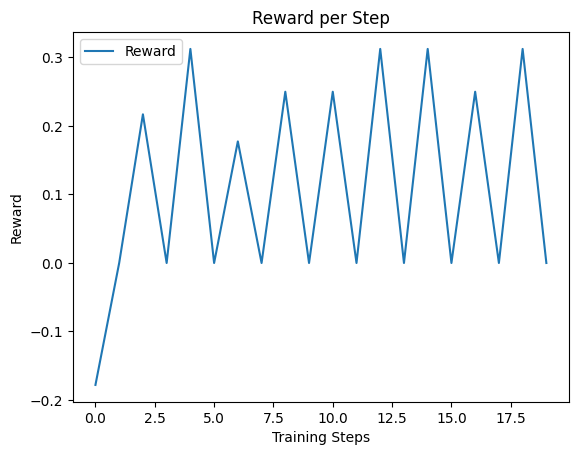

In [ ]:
import matplotlib.pyplot as plt

# Simple plot after training
plt.plot(epoch_rewards, label="Reward")
plt.xlabel("Training Steps")
plt.ylabel("Reward")
plt.title("Reward per Step")
plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Simple plot after training
plt.plot(correctness_reward_log, label="Reward")
plt.xlabel("Training Steps")
plt.ylabel("Reward")
plt.title("Reward per Step")
plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Simple plot after training
plt.plot(xmlcount_reward_func, label="Reward")
plt.xlabel("Training Steps")
plt.ylabel("Reward")
plt.title("Reward per Step")
plt.legend()
plt.show()


In [8]:
print(epoch_rewards)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [15]:
import re
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel
import torch
from datasets import load_dataset
from typing import List

# Load constants and helpers from your earlier code

SYSTEM_PROMPT = """
You are playing Wordle, a word-guessing game.

Think through the problem and feedback step by step. Make sure to first add your step by step thought process within <think> </think> tags. Then, return your guessed word in the following format: <guess> guessed-word </guess>.

Important: Your guess must always respect the previous feedback: all letters marked ✓ must be in the same position, letters marked - must be included but not in that position, and letters marked x must NOT appear in your guess.
"""

def extract_xml_answer(text: str) -> str:
    """Extracts the guessed word between <guess> tags."""
    try:
        answer = text.split("<guess>")[-1]
        answer = answer.split("</guess>")[0]
        return answer.strip()
    except Exception:
        return ""

def format_prompt(system_prompt: str, user_prompt: str, previous_dialogue: str = "") -> str:
    """Concatenate system prompt, user prompt, and previous dialogue for next input."""
    return system_prompt.strip() + "\n\n" + user_prompt.strip() + "\n" + previous_dialogue.strip()

def get_feedback(guess: str, secret: str) -> str:
    """
    Generate Wordle-like feedback string to guide the model.
    ✓ : letter correct and in correct position
    - : letter in word but wrong position
    x : letter not in word
    Format example: a ✓ p - p x
    """
    feedback = []
    secret_list = list(secret)
    guess_list = list(guess)
    
    # First mark correct positions
    feedback_marks = [''] * len(guess_list)
    for i in range(len(guess_list)):
        if guess_list[i] == secret_list[i]:
            feedback_marks[i] = '✓'
            secret_list[i] = None  # Remove matched letter
    
    # Mark misplaced and absent letters
    for i in range(len(guess_list)):
        if feedback_marks[i] == '':
            if guess_list[i] in secret_list:
                feedback_marks[i] = '-'
                secret_list[secret_list.index(guess_list[i])] = None
            else:
                feedback_marks[i] = 'x'
    
    # Format feedback as e.g. a ✓ p - p x
    feedback_str = ' '.join(f"{c} {m}" for c, m in zip(guess_list, feedback_marks))
    return feedback_str

def generate_guess(model, tokenizer, prompt: str, max_new_tokens=128, temperature=0.7) -> str:
    """Generate model output given prompt."""
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )
    generated_text = tokenizer.decode(outputs[0][inputs['input_ids'].shape[-1]:], skip_special_tokens=True)
    return generated_text

def get_wordle_dataset(split="train"):
    data = load_dataset("predibase/wordle-grpo", split=split)
    data = data.map(lambda x: {
        'prompt': [
            {'role': 'system', 'content': SYSTEM_PROMPT},
            {'role': 'user', 'content': x['prompt']}
        ],
        'answer': x['secret']
    })
    return data

# === Load model and tokenizer ===
base_ckpt = "Qwen/Qwen2.5-7B-Instruct"

print("Loading base model...")
model = AutoModelForCausalLM.from_pretrained(
    base_ckpt, device_map="auto", torch_dtype=torch.bfloat16, attn_implementation="eager"
)
print("Loading LoRA weights...")
model = PeftModel.from_pretrained(model, "grpo_Qwen")
model.eval()

print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained("grpo_Qwen")

# === Load dataset ===
print("Loading Wordle dataset...")
dataset = get_wordle_dataset("train")

# Let's test on first 6 samples
num_samples = 6

for idx in range(num_samples):
    print("="*40)
    print(f"Sample #{idx+1}")
    user_prompt = dataset[idx]['prompt'][1]['content']  # The user prompt text
    secret_word = dataset[idx]['answer']  # The secret Wordle word
    print(f"Secret word: {secret_word}")

    # Initialize dialogue context
    dialogue = ""
    # Start prompt
    prompt = format_prompt(SYSTEM_PROMPT, user_prompt, dialogue)

    for guess_num in range(1, 7):  # 6 guesses max
        output = generate_guess(model, tokenizer, prompt)
        guess_word = extract_xml_answer(output)

        # If guess extraction fails or guess empty, fallback:
        if not guess_word or len(guess_word) != 5:
            print(f"Invalid guess extracted: '{guess_word}', using fallback random guess 'arise'")
            guess_word = "arise"  # fallback guess

        print(f"Guess {guess_num}: {guess_word}")
        print(f"Model output:\n{output}\n")

        if guess_word.lower() == secret_word.lower():
            print(f"Guessed correctly in {guess_num} tries!")
            break

        # Generate feedback from Wordle rules
        feedback = get_feedback(guess_word.lower(), secret_word.lower())
        print(f"Feedback: {feedback}\n")

        # Append previous reasoning, guess, and feedback to dialogue
        dialogue += f"\n{output}\nFeedback for guess {guess_num}: {feedback}\n"

        # Build prompt for next turn
        prompt = format_prompt(SYSTEM_PROMPT, user_prompt, dialogue)

    print("="*40 + "\n\n")


Loading base model...


Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]


Loading LoRA weights...
Loading tokenizer...
Loading Wordle dataset...
Sample #1
Secret word: ABHOR
Guess 1: CRanE
Model output:
1. Since we have no initial feedback, we should start with a common 5-letter word that has a mix of vowels and consonants to gather more information about the word.
2. A good starting word could be "CRANE" as it contains a mix of vowels and consonants and includes some common letters.
</think>
<guess> CRanE </guess>

Feedback: c x r - a - n x e x

Invalid guess extracted: '- e x - 
Based on the feedback, none of the letters in "CRANE" are correct or in the right place. Let's try another approach.', using fallback random guess 'arise'
Guess 2: arise
Model output:
 - e x - 
Based on the feedback, none of the letters in "CRANE" are correct or in the right place. Let's try another approach.
</guess>

Feedback: a ✓ r - i x s x e x

Invalid guess extracted: 'Based on the feedback, 'a' is correct and in the right place, which is helps narrow down the possibilities. 

 PREMISE - CONCLUSION TRAINING USING GRPO --- LOG SAVED IN log_conclusion_1.txt


In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [12]:
import os
import random
from transformers import AutoTokenizer, AutoModelForCausalLM
from trl import GRPOTrainer, GRPOConfig
from datasets import Dataset

# ✅ NEW: PEFT (LoRA)
from peft import get_peft_model, LoraConfig, TaskType

# ========== STEP 1: Define your logic dataset ==========
# logic_data = [
#     {"prompt": "All humans are mortal. Socrates is a human. Therefore,", "answer": "Socrates is mortal."},
#     {"prompt": "All birds can fly. A penguin is a bird. Therefore,", "answer": "A penguin can fly."},  # Wrong logic
#     {"prompt": "All cats are animals. A tiger is a cat. Therefore,", "answer": "A tiger is an animal."},
#     {"prompt": "If it rains, the ground gets wet. It is raining. Therefore,", "answer": "The ground gets wet."},
#     {"prompt": "All fish live in water. A shark is a fish. Therefore,", "answer": "A shark lives in water."},
# ]

logic_data = [
    {
        "prompt": "Given the premises: 'All humans are mortal' and 'Socrates is a human', write the logical conclusion in one sentence.",
        "answer": "Socrates is mortal."
    },
    {
        "prompt": "Given the premises: 'All birds can fly' and 'A penguin is a bird', write the logical conclusion in one sentence.",
        "answer": "A penguin can fly."  # still logically incorrect but part of dataset for training reward
    },
    {
        "prompt": "Given the premises: 'All cats are animals' and 'A tiger is a cat', write the logical conclusion in one sentence.",
        "answer": "A tiger is an animal."
    },
    {
        "prompt": "Given the premises: 'If it rains, the ground gets wet' and 'It is raining', write the logical conclusion in one sentence.",
        "answer": "The ground gets wet."
    },
    {
        "prompt": "Given the premises: 'All fish live in water' and 'A shark is a fish', write the logical conclusion in one sentence.",
        "answer": "A shark lives in water."
    },
]


expanded_data = logic_data * 25  # Now 125 examples
random.shuffle(expanded_data)

dataset = Dataset.from_list([{"prompt": d["prompt"], "answer": d["answer"]} for d in expanded_data])

# ========== STEP 2: Load model and tokenizer ==========
model_name = "microsoft/phi-2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

base_model = AutoModelForCausalLM.from_pretrained(model_name)

# ========== STEP 3: Apply LoRA via PEFT ==========
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none",
    target_modules=["q_proj", "v_proj"],  # or use ["c_attn"] for GPT-style
)

model = get_peft_model(base_model, peft_config)
model.print_trainable_parameters()  # ✅ Shows how few parameters are being trained

# ========== STEP 4: Define reward function ==========
# def reward_func(prompts, completions, completion_ids, **kwargs):
#     rewards = []
#     for completion in completions:
#         output = completion.strip()
#         match_found = any(output.endswith(data["answer"]) for data in logic_data)
#         rewards.append(1.0 if match_found else 0.0)
#     return rewards

# def reward_func(prompts, completions, completion_ids, **kwargs):
#     rewards = []
    
#     for i, (prompt, completion) in enumerate(zip(prompts, completions)):
#         output = completion.strip().lower()
#         match_found = any(output.endswith(data["answer"]) for data in logic_data)
#         reward = 1.0 if match_found else 0.0
#         rewards.append(reward)

#         # 🔄 Print all completions for each prompt
#         print("=" * 50)
#         print(f"[Sample {i+1}]")
#         print(f"Prompt       : {prompt}")
#         print(f"Completion   : {output}")
#         print(f"Reward Score : {reward}")
#         print("=" * 50)

#     return rewards

import re

def clean_text(text):
    text = text.lower()
    # Remove common prefixes/tags
    text = re.sub(r'^(output|answer|completion|premises|ai|input|assistant|solution|response):\s*', '', text)
    # Remove punctuation except apostrophes inside words
    text = re.sub(r'[^\w\s\']', '', text)
    # Normalize whitespace
    text = ' '.join(text.split())
    return text

def reward_func(prompts, completions, completion_ids, **kwargs):
    rewards = []
    for i, completion in enumerate(completions):
        output_clean = clean_text(completion)
        matched = False
        for data in logic_data:
            answer_clean = clean_text(data["answer"])
            if answer_clean in output_clean:
                matched = True
                break
        reward = 1.0 if matched else 0.0

        print("="*50)
        print(f"[Sample {i+1}]")
        print(f"Prompt       : {prompts[i]}")
        print(f"Completion   : {completion.strip()}")
        print(f"Reward Score : {reward}")
        print("="*50)

        rewards.append(reward)
    return rewards




# ========== STEP 5: Configure GRPO training ==========
grpo_config = GRPOConfig(
    output_dir="grpo-logic-output",
    per_device_train_batch_size=1,
    generation_batch_size=2,
    num_train_epochs=2,
    learning_rate=1e-4,
    num_generations=2,  # group size
    logging_steps=5,
    remove_unused_columns=False,
    report_to=[],
    max_completion_length=20,
)

# ========== STEP 6: Initialize Trainer ==========
trainer = GRPOTrainer(
    model=model,
    args=grpo_config,
    train_dataset=dataset,
    reward_funcs=[reward_func],
)

# ========== STEP 7: Start training ==========
trainer.train()

# Save the LoRA adapter (not full model unless merged)
trainer.save_model("grpo-lora-model")


Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  3.28it/s]


trainable params: 2,621,440 || all params: 2,782,305,280 || trainable%: 0.0942


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 50256}.
/home/athenaik/GRPO_test/.venv/lib/python3.11/site-packages/torch/utils/checkpoint.py:86: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


[Sample 1]
Prompt       : Given the premises: 'All birds can fly' and 'A penguin is a bird', write the logical conclusion in one sentence.
Completion   : Output: The conclusion is 'Therefore, a penguin can fly.'
Reward Score : 1.0
[Sample 2]
Prompt       : Given the premises: 'All birds can fly' and 'A penguin is a bird', write the logical conclusion in one sentence.
Completion   : (2 points)

(c) Write three statements that would counterexample the claim
Reward Score : 0.0


Step,Training Loss
5,-0.053600
10,0.092000
15,0.099500
20,-0.064400
25,0.067500
30,-0.073600
35,0.087400
40,-0.070200
45,0.000000
50,0.000000


[Sample 1]
Prompt       : Given the premises: 'All birds can fly' and 'A penguin is a bird', write the logical conclusion in one sentence.
Completion   : Solution: The conclusion is 'Therefore, a penguin can fly.'

Example Follow
Reward Score : 1.0
[Sample 2]
Prompt       : Given the premises: 'All birds can fly' and 'A penguin is a bird', write the logical conclusion in one sentence.
Completion   : Input: 
Output: The logical conclusion is: 'A penguin can fly.'
Reward Score : 1.0
[Sample 1]
Prompt       : Given the premises: 'All fish live in water' and 'A shark is a fish', write the logical conclusion in one sentence.
Completion   : Input: 
Output: The logical conclusion is: 'A shark lives in water'.
Reward Score : 1.0
[Sample 2]
Prompt       : Given the premises: 'All fish live in water' and 'A shark is a fish', write the logical conclusion in one sentence.
Completion   : Premises: ['All dogs have tails', 'Fido is a dog'].
Output:
Reward Score : 0.0
[Sample 1]
Prompt       : Given t

In [ ]:
import os
import random
from transformers import AutoTokenizer, AutoModelForCausalLM
from trl import GRPOTrainer, GRPOConfig
from datasets import Dataset

# ✅ NEW: PEFT (LoRA)
from peft import get_peft_model, LoraConfig, TaskType

# ========== STEP 1: Define your logic dataset ==========
# logic_data = [
#     {"prompt": "All humans are mortal. Socrates is a human. Therefore,", "answer": "Socrates is mortal."},
#     {"prompt": "All birds can fly. A penguin is a bird. Therefore,", "answer": "A penguin can fly."},  # Wrong logic
#     {"prompt": "All cats are animals. A tiger is a cat. Therefore,", "answer": "A tiger is an animal."},
#     {"prompt": "If it rains, the ground gets wet. It is raining. Therefore,", "answer": "The ground gets wet."},
#     {"prompt": "All fish live in water. A shark is a fish. Therefore,", "answer": "A shark lives in water."},
# ]

math_data = [
    {"prompt": "Solve the following and give just a number: What is 7 plus 5?", "answer": "12"},
    {"prompt": "Solve the following and give just a number: If you have 3 apples and you get 4 more, how many apples do you have?", "answer": "7"},
    {"prompt": "Solve the following and give just a number: Calculate the product of 6 and 9.", "answer": "54"},
    {"prompt": "Solve the following and give just a number: What is 15 divided by 3?", "answer": "5"},
    {"prompt": "Solve the following and give just a number: Subtract 8 from 20.", "answer": "12"},
    {"prompt": "Solve the following and give just a number: Add 14 and 28.", "answer": "42"},
    {"prompt": "Solve the following and give just a number: What is 9 times 7?", "answer": "63"},
    {"prompt": "Solve the following and give just a number: Divide 81 by 9.", "answer": "9"},
    {"prompt": "Solve the following and give just a number: If you have 20 candies and eat 5, how many are left?", "answer": "15"},
    {"prompt": "Solve the following and give just a number: Multiply 12 by 4.", "answer": "48"},
    {"prompt": "Solve the following and give just a number: What is the sum of 100 and 250?", "answer": "350"},
    {"prompt": "Solve the following and give just a number: Subtract 45 from 100.", "answer": "55"},
    {"prompt": "Solve the following and give just a number: If a car travels 60 miles in 1 hour, how far will it travel in 3 hours?", "answer": "180"},
    {"prompt": "Solve the following and give just a number: What is 8 multiplied by 8?", "answer": "64"},
    {"prompt": "Solve the following and give just a number: Divide 144 by 12.", "answer": "12"},
    {"prompt": "Solve the following and give just a number: Add 33 and 67.", "answer": "100"},
    {"prompt": "Solve the following and give just a number: If you buy 5 packs with 10 pencils each, how many pencils do you have?", "answer": "50"},
    {"prompt": "Solve the following and give just a number: What is 45 minus 19?", "answer": "26"},
    {"prompt": "Solve the following and give just a number: Multiply 7 by 11.", "answer": "77"},
    {"prompt": "Solve the following and give just a number: Divide 56 by 7.", "answer": "8"},
    {"prompt": "Solve the following and give just a number: Add 5 to 100.", "answer": "105"},
    {"prompt": "Solve the following and give just a number: Subtract 12 from 25.", "answer": "13"},
    {"prompt": "Solve the following and give just a number: What is 13 times 6?", "answer": "78"},
    {"prompt": "Solve the following and give just a number: Divide 90 by 10.", "answer": "9"},
    {"prompt": "Solve the following and give just a number: If a bus holds 40 people and 28 get on, how many seats remain?", "answer": "12"},
    {"prompt": "Solve the following and give just a number: What is 3 plus 14?", "answer": "17"},
    {"prompt": "Solve the following and give just a number: Multiply 9 by 5.", "answer": "45"},
    {"prompt": "Solve the following and give just a number: Divide 100 by 25.", "answer": "4"},
    {"prompt": "Solve the following and give just a number: Subtract 7 from 50.", "answer": "43"},
    {"prompt": "Solve the following and give just a number: Add 200 and 350.", "answer": "550"},
    {"prompt": "Solve the following and give just a number: What is the product of 14 and 3?", "answer": "42"},
    {"prompt": "Solve the following and give just a number: Divide 36 by 6.", "answer": "6"},
    {"prompt": "Solve the following and give just a number: If you have 8 packs of gum with 9 pieces each, how many pieces do you have?", "answer": "72"},
    {"prompt": "Solve the following and give just a number: Subtract 30 from 80.", "answer": "50"},
    {"prompt": "Solve the following and give just a number: Add 11 and 44.", "answer": "55"},
    {"prompt": "Solve the following and give just a number: Multiply 15 by 2.", "answer": "30"},
    {"prompt": "Solve the following and give just a number: Divide 60 by 5.", "answer": "12"},
    {"prompt": "Solve the following and give just a number: What is 7 minus 2?", "answer": "5"},
    {"prompt": "Solve the following and give just a number: Add 17 to 83.", "answer": "100"},
    {"prompt": "Solve the following and give just a number: Multiply 4 by 13.", "answer": "52"},
    {"prompt": "Solve the following and give just a number: Divide 72 by 9.", "answer": "8"},
    {"prompt": "Solve the following and give just a number: If a box contains 6 rows of 7 chocolates, how many chocolates are there?", "answer": "42"},
    {"prompt": "Solve the following and give just a number: Subtract 18 from 40.", "answer": "22"},
    {"prompt": "Solve the following and give just a number: Add 25 and 35.", "answer": "60"},
    {"prompt": "Solve the following and give just a number: Multiply 10 by 10.", "answer": "100"},
    {"prompt": "Solve the following and give just a number: Divide 48 by 8.", "answer": "6"},
    {"prompt": "Solve the following and give just a number: What is 9 plus 11?", "answer": "20"},
    {"prompt": "Solve the following and give just a number: Subtract 16 from 30.", "answer": "14"},
]


# expanded_data = logic_data * 25  # Now 125 examples
# random.shuffle(expanded_data)

# dataset = Dataset.from_list([{"prompt": d["prompt"], "answer": d["answer"]} for d in expanded_data])

# Option 2: Use original dataset directly for shorter training
dataset = Dataset.from_list([{"prompt": d["prompt"], "answer": d["answer"]} for d in math_data])


# ========== STEP 2: Load model and tokenizer ==========
model_name = "microsoft/phi-2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

base_model = AutoModelForCausalLM.from_pretrained(model_name)

# ========== STEP 3: Apply LoRA via PEFT ==========
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none",
    target_modules=["q_proj", "v_proj"],  # or use ["c_attn"] for GPT-style
)

model = get_peft_model(base_model, peft_config)
model.print_trainable_parameters()  # ✅ Shows how few parameters are being trained


import re

def clean_text(text):
    text = text.lower()
    # Remove common prefixes/tags
    text = re.sub(r'^(output|answer|completion|premises|ai|input|assistant|solution|response):\s*', '', text)
    # Remove punctuation except apostrophes inside words
    text = re.sub(r'[^\w\s\']', '', text)
    # Normalize whitespace
    text = ' '.join(text.split())
    return text

def reward_func(prompts, completions, completion_ids, **kwargs):
    rewards = []
    for i, completion in enumerate(completions):
        output_clean = clean_text(completion)
        matched = False
        for data in math_data:
            answer_clean = clean_text(data["answer"])
            if answer_clean in output_clean:
                matched = True
                break
        reward = 1.0 if matched else 0.0

        print("="*50)
        print(f"[Sample {i+1}]")
        print(f"Prompt       : {prompts[i]}")
        print(f"Completion   : {completion.strip()}")
        print(f"Reward Score : {reward}")
        print("="*50)

        rewards.append(reward)
    return rewards

# ========== STEP 5: Configure GRPO training ==========
grpo_config = GRPOConfig(
    output_dir="grpo-logic-output",
    per_device_train_batch_size=1,
    generation_batch_size=2,
    num_train_epochs=5,
    learning_rate=1e-4,
    num_generations=2,  # group size
    logging_steps=5,
    remove_unused_columns=False,
    report_to=[],
    max_completion_length=20,
)

# ========== STEP 6: Initialize Trainer ==========
trainer = GRPOTrainer(
    model=model,
    args=grpo_config,
    train_dataset=dataset,
    reward_funcs=[reward_func],
)

# ========== STEP 7: Start training ==========
trainer.train()

# Save the LoRA adapter (not full model unless merged)
trainer.save_model("grpo-lora-model")


Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  3.32it/s]


trainable params: 2,621,440 || all params: 2,782,305,280 || trainable%: 0.0942


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 50256}.
/home/athenaik/GRPO_test/.venv/lib/python3.11/site-packages/torch/utils/checkpoint.py:86: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


[Sample 1]
Prompt       : Solve the following and give just a number: What is 9 times 7?
Completion   : ## INPUT
9 times 7
##OUTPUT
63
Reward Score : 1.0
[Sample 2]
Prompt       : Solve the following and give just a number: What is 9 times 7?
Completion   : 2.How much is 20% of 84? 
3. What is the result of
Reward Score : 1.0


Step,Training Loss
5,0.033100
10,0.000000
15,0.091100
20,0.006800
25,0.004200
30,0.000000
35,0.000000
40,0.000000
45,0.000000
50,0.000000


[Sample 1]
Prompt       : Solve the following and give just a number: If you buy 5 packs with 10 pencils each, how many pencils do you have?
Completion   : Solution:
To find the total number of pencils, we need to multiply the number
Reward Score : 0.0
[Sample 2]
Prompt       : Solve the following and give just a number: If you buy 5 packs with 10 pencils each, how many pencils do you have?
Completion   : <|question_end|>Answer: 50
Reward Score : 1.0
[Sample 1]
Prompt       : Solve the following and give just a number: Calculate the product of 6 and 9.
Completion   : Li is driving to France from the UK.
She will drive a total distance of 275 miles
Reward Score : 1.0
[Sample 2]
Prompt       : Solve the following and give just a number: Calculate the product of 6 and 9.
Completion   : Output: 54
Reward Score : 1.0
[Sample 1]
Prompt       : Solve the following and give just a number: Divide 81 by 9.
Completion   : Answer:  9
Reward Score : 1.0
[Sample 2]
Prompt       : Solve the following

In [3]:
import os
import re
from transformers import AutoTokenizer, AutoModelForCausalLM
from trl import GRPOTrainer, GRPOConfig
from datasets import load_dataset, Dataset
from peft import get_peft_model, LoraConfig, TaskType

# ========== STEP 1: Load Wordle Dataset ==========

SYSTEM_PROMPT = "You are a helpful assistant solving Wordle puzzles."

def get_wordle_dataset(split="train"):
    data = load_dataset("predibase/wordle-grpo", split=split)

    # Add prompt with roles
    data = data.map(lambda x: {
        'prompt': [
            {'role': 'system', 'content': SYSTEM_PROMPT},
            {'role': 'user', 'content': x['prompt']}
        ],
        'answer': x['secret']
    })
    return data

def flatten_wordle_dataset(wordle_dataset):
    def combine_roles(example):
        system_content = example['prompt'][0]['content']
        user_content = example['prompt'][1]['content']
        combined_prompt = system_content + "\n" + user_content
        return {"prompt": combined_prompt, "answer": example["answer"]}
    
    return wordle_dataset.map(combine_roles, remove_columns=['prompt'])

# Prepare final dataset
dataset = flatten_wordle_dataset(get_wordle_dataset())
dataset = dataset.shuffle(seed=42)  # Optional shuffle

# ========== STEP 2: Load model and tokenizer ==========

model_name = "microsoft/phi-2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

base_model = AutoModelForCausalLM.from_pretrained(model_name)

# ========== STEP 3: Apply LoRA via PEFT ==========

peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none",
    target_modules=["q_proj", "v_proj"],
)

model = get_peft_model(base_model, peft_config)
model.print_trainable_parameters()

# ========== STEP 4: Reward Function ==========

def clean_text(text):
    text = text.lower()
    text = re.sub(r'^(output|answer|completion|premises|ai|input|assistant|solution|response):\s*', '', text)
    text = re.sub(r'[^\w\s\']', '', text)
    text = ' '.join(text.split())
    return text

# Updated reward function uses answer from dataset directly
def reward_func(prompts, completions, completion_ids, **kwargs):
    answers = kwargs.get("answers", [])  # List of ground-truth answers
    rewards = []

    for i, completion in enumerate(completions):
        output_clean = clean_text(completion)

        # Fetch correct answer using group index
        group_index = completion_ids[i][0] if isinstance(completion_ids[i], list) else completion_ids[i]
        expected_answer = clean_text(answers[group_index]) if group_index < len(answers) else ""

        reward = 1.0 if expected_answer in output_clean else 0.0

        print("="*50)
        print(f"[Sample {i+1}]")
        print(f"Prompt       : {prompts[i]}")
        print(f"Completion   : {completion.strip()}")
        print(f"Expected Ans : {expected_answer}")
        print(f"Reward Score : {reward}")
        print("="*50)

        rewards.append(reward)

    return rewards


# ========== STEP 5: GRPO Configuration ==========

grpo_config = GRPOConfig(
    output_dir="grpo-wordle-output",
    per_device_train_batch_size=1,
    generation_batch_size=2,
    num_train_epochs=5,
    learning_rate=1e-4,
    num_generations=2,  # group size
    logging_steps=5,
    remove_unused_columns=False,
    report_to=[],
    max_completion_length=20,
)

# ========== STEP 6: Initialize Trainer ==========

trainer = GRPOTrainer(
    model=model,
    args=grpo_config,
    train_dataset=dataset,
    reward_funcs=[reward_func],
)

# ========== STEP 7: Start Training ==========

trainer.train()

# Save the LoRA adapter (not full model unless merged)
trainer.save_model("grpo-lora-model")


Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  2.95it/s]


trainable params: 2,621,440 || all params: 2,782,305,280 || trainable%: 0.0942


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 50256}.
/home/athenaik/GRPO_test/.venv/lib/python3.11/site-packages/torch/utils/checkpoint.py:86: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


[Sample 1]
Prompt       : You are a helpful assistant solving Wordle puzzles.
<|im_start|>system

You are playing Wordle, a word-guessing game.

### Game Rules:
- You have **6 tries** to guess a secret **5-letter** word.
- Each guess must be a valid **5-letter English word**.
- After each guess, you will receive feedback indicating how close your guess was.

### Feedback Format:
Each letter in your guess will receive one of three symbols:
1. ✓ : The letter is in the word and in the CORRECT position.
2. - : The letter is in the word but in the WRONG position.
3. x : The letter is NOT in the word.

### Example:
Secret Word: BRISK

Guess 1: STORM → Feedback: S(-) T(x) O(x) R(-) M(x)
Guess 2: BRAVE → Feedback: B(✓) R(✓) A(x) V(x) E(x)
Guess 3: BRISK → Feedback: B(✓) R(✓) I(✓) S(✓) K(✓)

### Response Format:
Think through the problem and feedback step by step. Make sure to first add your step by step thought process within <think> </think> tags. Then, return your guessed word in the followi

Step,Training Loss
5,0.000000
10,0.000000
15,0.000000
20,0.000000
25,0.000000
30,0.000000
35,0.000000
40,0.000000
45,0.000000
50,0.000000


[Sample 1]
Prompt       : You are a helpful assistant solving Wordle puzzles.
<|im_start|>system

You are playing Wordle, a word-guessing game.

### Game Rules:
- You have **6 tries** to guess a secret **5-letter** word.
- Each guess must be a valid **5-letter English word**.
- After each guess, you will receive feedback indicating how close your guess was.

### Feedback Format:
Each letter in your guess will receive one of three symbols:
1. ✓ : The letter is in the word and in the CORRECT position.
2. - : The letter is in the word but in the WRONG position.
3. x : The letter is NOT in the word.

### Example:
Secret Word: BRISK

Guess 1: STORM → Feedback: S(-) T(x) O(x) R(-) M(x)
Guess 2: BRAVE → Feedback: B(✓) R(✓) A(x) V(x) E(x)
Guess 3: BRISK → Feedback: B(✓) R(✓) I(✓) S(✓) K(✓)

### Response Format:
Think through the problem and feedback step by step. Make sure to first add your step by step thought process within <think> </think> tags. Then, return your guessed word in the followi

KeyboardInterrupt: 

In [3]:
import os
import re
from transformers import AutoTokenizer, AutoModelForCausalLM
from trl import GRPOTrainer, GRPOConfig
from datasets import Dataset
from peft import get_peft_model, LoraConfig, TaskType
import reasoning_gym
from reasoning_gym import get_score_answer_fn

# ========== STEP 1: Generate Shortest Path Data ==========

def get_shortest_path_dataset(size=100, seed=42):
    raw = reasoning_gym.create_dataset('family_relationships', size=size, seed=seed)
    records = [
        {"prompt": x["question"], "answer": x["answer"], "metadata": x["metadata"]}
        for x in raw
    ]
    return Dataset.from_list(records), raw  # return both HF dataset and original entries

dataset, raw_entries = get_shortest_path_dataset(size=100, seed=123)

# ========== STEP 2: Load model and tokenizer ==========

model_name = "microsoft/phi-2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
base_model = AutoModelForCausalLM.from_pretrained(model_name)

peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=8, lora_alpha=16, lora_dropout=0.05, bias="none",
    target_modules=["q_proj", "v_proj"],
)

model = get_peft_model(base_model, peft_config)
model.print_trainable_parameters()

# ========== STEP 3: Reward Function Using RG Verifier ==========

def clean_text(text):
    text = text.lower().strip()
    return re.sub(r'[^a-z\s]', '', text)

def reward_func(prompts, completions, completion_ids, **kwargs):
    metadata = kwargs.get("metadata", [])  # safely get metadata here
    rewards = []

    for i, completion in enumerate(completions):
        idx = completion_ids[i][0] if isinstance(completion_ids[i], list) else completion_ids[i]
        entry = metadata[idx]
        score_fn = get_score_answer_fn(entry["metadata"]["source_dataset"])
        reward = float(score_fn(completion, entry))

        print(f"[Sample {i+1}]")
        print(f"Prompt       : {prompts[i]}")
        print(f"Completion   : {completion.strip()}")
        print(f"Reward Score : {reward}")
        print("="*40)

        rewards.append(reward)

    return rewards



# ========== STEP 4: GRPO Configuration ==========

grpo_config = GRPOConfig(
    output_dir="grpo-shortest-path",
    per_device_train_batch_size=1,
    generation_batch_size=2,
    num_train_epochs=5,
    learning_rate=1e-4,
    num_generations=2,
    logging_steps=5,
    remove_unused_columns=False,
    report_to=[],
    max_completion_length=50,
)

# ========== STEP 5: Initialize Trainer with RG Rewards ==========

trainer = GRPOTrainer(
    model=model,
    args=grpo_config,
    train_dataset=dataset,
    reward_funcs=[lambda prompts, completions, completion_ids, **kwargs: reward_func(prompts, completions, completion_ids, metadata=raw_entries)],
)


# ========== STEP 6: Train and Save ==========

trainer.train()
trainer.save_model("grpo-lora-shortest-path")


INFO 09-10 16:18:22 [__init__.py:241] Automatically detected platform cuda.


Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  3.37it/s]


trainable params: 2,621,440 || all params: 2,782,305,280 || trainable%: 0.0942


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 50256}.
/home/athenaik/GRPO_test/.venv/lib/python3.11/site-packages/torch/utils/checkpoint.py:86: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


[Sample 1]
Prompt       : Michael is married to Lucy. They have a child called David. David is married to Zoe.

How is Lucy related to Michael? Provide the relationship in one word.
Completion   : A) Mother
B) Child
C) Sibling
D) Aunt
E) None of these

Solution:
--------------------

To understand the relationship between Lucy and Michael, we need to use the information given in
Reward Score : 0.0
[Sample 2]
Prompt       : Michael is married to Lucy. They have a child called David. David is married to Zoe.

How is Lucy related to Michael? Provide the relationship in one word.
Completion   : (2 points)

How is Zoe related to Michael? Provide the relationship in one word. (2 points)

How is David related to Michael? Provide the relationship in one word. (2 points)

<|question_
Reward Score : 0.0


Step,Training Loss
5,0.000000
10,0.000000
15,0.000000
20,0.000000
25,0.000000
30,0.000000
35,0.000000
40,0.000000
45,0.000000
50,0.000000


[Sample 1]
Prompt       : Liam is married to Jennifer. They have a child called Oliver. Oliver is married to Jessica. They have children called Sophie and Luna.

What relation is Jennifer to Liam? Answer with a single word.
Completion   : She is his girlfriend.
Reward Score : 0.0
[Sample 2]
Prompt       : Liam is married to Jennifer. They have a child called Oliver. Oliver is married to Jessica. They have children called Sophie and Luna.

What relation is Jennifer to Liam? Answer with a single word.
Completion   : Answer: wife.
Reward Score : 0.0
[Sample 1]
Prompt       : Charles is married to Karen. They have a child called Alexander. Alexander is married to Sage.

What relation is Sage to Karen? Answer with a single word.
Completion   : Logical Puzzle 1 Answer: Relative
Logical Puzzle 2 Answer: Spouse

Topic: Entertainment
Reward Score : 0.0
[Sample 2]
Prompt       : Charles is married to Karen. They have a child called Alexander. Alexander is married to Sage.

What relation is Sage 

KeyboardInterrupt: 

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from reasoning_gym import create_dataset

def extract_answer(generated_text):
    # Split on 'Answer:'
    parts = generated_text.split("Answer:")
    if len(parts) < 2:
        return ""
    last_part = parts[-1].strip()  # take text after last "Answer:"
    
    # Sometimes the answer ends with new lines or extra text, take first word only
    if len(last_part) == 0:
        return ""
    
    answer_word = last_part.split()[0]
    return answer_word

def safe_extract_answer(text):
    parts = text.split("Answer:")
    if len(parts) < 2:
        return ""
    last_part = parts[-1].strip()
    if not last_part:
        return ""
    words = last_part.split()
    if len(words) == 0:
        return ""
    return words[0]




def main():
    # Parameters
    model_name = "microsoft/phi-2"
    dataset_name = "family_relationships"
    size = 100  # number of samples to test
    seed = 42

    # Load dataset
    raw = create_dataset(dataset_name, size=size, seed=seed)
    samples = raw

    # Load model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name)
    model.eval()
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    correct = 0

    for i, sample in enumerate(samples):
        question = sample['question']
        answer = sample['answer']

        # Prepare prompt - depends on your task structure
        input_text = question + "\nAnswer:"
        inputs = tokenizer(input_text, return_tensors="pt").to(device)

        # Generate output with model
        with torch.no_grad():
            outputs = model.generate(**inputs, max_new_tokens=20)
        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

        model_answer = extract_answer(generated_text)

        print(f"Question: {question}")
        print(f"Expected answer: {answer}")
        print(f"Model answer: {model_answer}")
        print("-" * 40)


        # Extract model's answer after "Answer:" prompt
        model_answer = safe_extract_answer(generated_text)

        # Compare with ground truth (simple equality check, can customize)
        if model_answer.lower() == answer.lower():
            correct += 1

        if (i+1) % 10 == 0:
            print(f"Processed {i+1} samples, current accuracy: {correct/(i+1):.2f}")

    print(f"Final accuracy on {size} samples: {correct/size:.2f}")

if __name__ == "__main__":
    main()


/home/athenaik/GRPO_test/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  3.01it/s]
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: John is married to Isabella. They have a child called Edward. Edward is married to Victoria.

What is Isabella to Edward? Respond only with the word that describes their relationship.
Expected answer: mother
Model answer: Mother
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Henry is married to Karen. They have a child called Sebastian. Sebastian is married to Eleanor.

What relation is Henry to Karen? Answer with a single word.
Expected answer: husband
Model answer: 
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Liam is married to Nova. They have a child called Noah. Noah is married to Charlotte. They have a child called Patricia. Joseph is married to Lisa. They have a child called Charlotte.

What is Liam to Noah? Respond only with the word that describes their relationship.
Expected answer: father
Model answer: Father
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Ethan is married to Hannah. They have a child called Edward. Edward is married to Barbara. They have children called Abigail and Owen.

What is Ethan to Edward? Respond only with the word that describes their relationship.
Expected answer: father
Model answer: Father
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Noah is married to Jennifer. They have a child called Phoenix. Phoenix is married to Sage.

What relation is Jennifer to Phoenix? Answer with a single word.
Expected answer: mother
Model answer: Sister
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: William is married to Lucy. They have a child called Jayden. Jayden is married to Lily. They have children called Sophia and Rain.

What is Lily to William? Respond only with the word that describes their relationship.
Expected answer: father-in-law
Model answer: Daughter
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Alexander is married to Sarah. They have a child called Samuel. Samuel is married to Luna. They have children called Logan and Richard. Jayden is married to Aria. They have a child called Luna.

What is Jayden to Aria? Respond only with the word that describes their relationship.
Expected answer: husband
Model answer: Ari
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Jack is married to Alice. They have a child called Joseph. Joseph is married to Mia.

What is Jack to Joseph? Respond only with the word that describes their relationship.
Expected answer: father
Model answer: Father
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Benjamin is married to Amelia. They have a child called Theodore. Theodore is married to Abigail. They have a child called Jayden. Ryder is married to Charlotte. They have a child called Abigail.

What is Theodore to Benjamin? Respond only with the word that describes their relationship.
Expected answer: son
Model answer: Son
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Owen is married to Aria. They have a child called Peter. Peter is married to Charlotte. They have a child called Zion.

What relation is Charlotte to Zion? Answer with a single word.
Expected answer: mother
Model answer: Sister
----------------------------------------
Processed 10 samples, current accuracy: 0.50


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Michael is married to Zoe. They have a child called Theodore. Theodore is married to Amelia. They have children called Jennifer and Lucas.

What relation is Theodore to Amelia? Answer with a single word.
Expected answer: husband
Model answer: Daughter
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Christopher is married to Sophie. They have a child called Kai. Kai is married to Amelia. They have children called Patricia and Harry. Liam is married to Hannah. They have a child called Amelia.

What is Kai to Amelia? Respond only with the word that describes their relationship.
Expected answer: husband
Model answer: Son
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Mason is married to Aria. They have a child called Samuel. Samuel is married to Lily. They have a child called Eleanor.

What relation is Lily to Samuel? Answer with a single word.
Expected answer: wife
Model answer: Daughter
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Matthew is married to Karen. They have a child called Alexander. Alexander is married to Barbara.

What relation is Matthew to Karen? Answer with a single word.
Expected answer: husband
Model answer: Son
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: James is married to Lily. They have a child called Alexander. Alexander is married to Willow. They have children called Victoria and Elizabeth. Finn is married to Nova. They have a child called Willow.

What is Alexander to Elizabeth? Respond only with the word that describes their relationship.
Expected answer: father
Model answer: Son
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Harry is married to Aurora. They have a child called Atlas. Atlas is married to Patricia.

How is Aurora related to Atlas? Provide the relationship in one word.
Expected answer: mother
Model answer: Aunt
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Matthew is married to Margaret. They have a child called Robert. Robert is married to Victoria. They have children called Chloe and Ava. Finn is married to Anna. They have a child called Victoria.

How is Margaret related to Matthew? Provide the relationship in one word.
Expected answer: wife
Model answer: Mother
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: David is married to Sky. They have a child called Sebastian. Sebastian is married to Patricia. They have a child called Alexander.

How is Patricia related to Alexander? Provide the relationship in one word.
Expected answer: mother
Model answer: Granddaughter
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Henry is married to Willow. They have a child called Charles. Charles is married to Sophia. They have children called Owen and Jennifer.

What relation is Henry to Willow? Answer with a single word.
Expected answer: husband
Model answer: 
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Daniel is married to Aria. They have a child called Alexander. Alexander is married to Emily. They have a child called Aiden. Andrew is married to Mia. They have a child called Emily.

How is Mia related to Aiden? Provide the relationship in one word.
Expected answer: grandmother
Model answer: Mia
----------------------------------------
Processed 20 samples, current accuracy: 0.25


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Daniel is married to Elizabeth. They have a child called Oliver. Oliver is married to Amelia. They have children called Kai and James. Edward is married to Lily. They have a child called Amelia.

What is Edward to Kai? Respond only with the word that describes their relationship.
Expected answer: grandfather
Model answer: Oliver
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Mason is married to Olivia. They have a child called David. David is married to Grace. They have a child called William. Edward is married to Hannah. They have a child called Grace.

How is William related to Grace? Provide the relationship in one word.
Expected answer: son
Model answer: William
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Joseph is married to Winter. They have a child called Kai. Kai is married to Patricia. They have a child called Henry. Axel is married to Grace. They have a child called Patricia.

What is Patricia to Henry? Respond only with the word that describes their relationship.
Expected answer: mother
Model answer: Patricia
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Henry is married to Olivia. They have a child called Logan. Logan is married to Hannah. They have a child called Sage. Liam is married to Victoria. They have a child called Hannah.

How is Sage related to Hannah? Provide the relationship in one word.
Expected answer: daughter
Model answer: Logan
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Samuel is married to Lucy. They have a child called George. George is married to Sophie.

What relation is George to Lucy? Answer with a single word.
Expected answer: son
Model answer: Grandson
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Joseph is married to Alice. They have a child called Sebastian. Sebastian is married to Lucy.

How is Sebastian related to Lucy? Provide the relationship in one word.
Expected answer: husband
Model answer: Sebastian
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Owen is married to Jessica. They have a child called George. George is married to Chloe. They have a child called Isabella. Atlas is married to Sage. They have a child called Chloe.

What is George to Chloe? Respond only with the word that describes their relationship.
Expected answer: husband
Model answer: Son
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Richard is married to Emma. They have a child called William. William is married to River.

What relation is William to Emma? Answer with a single word.
Expected answer: son
Model answer: Brother
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Henry is married to Sophie. They have a child called Logan. Logan is married to Sarah.

What is Logan to Henry? Respond only with the word that describes their relationship.
Expected answer: son
Model answer: Son
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Owen is married to River. They have a child called James. James is married to Sophia. They have children called Christopher and Andrew.

How is Andrew related to Christopher? Provide the relationship in one word.
Expected answer: brother
Model answer: Brother
----------------------------------------
Processed 30 samples, current accuracy: 0.23


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Phoenix is married to Lisa. They have a child called Jack. Jack is married to Aria.

What relation is Jack to Lisa? Answer with a single word.
Expected answer: son
Model answer: Son
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Joseph is married to Zoe. They have a child called Theodore. Theodore is married to Aurora. They have children called Sebastian and Aiden.

What is Sebastian to Aiden? Respond only with the word that describes their relationship.
Expected answer: brother
Model answer: Son
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Owen is married to Jessica. They have a child called Samuel. Samuel is married to Margaret. They have children called Jacob and Zoe. Alexander is married to Sarah. They have a child called Margaret.

What relation is Margaret to Alexander? Answer with a single word.
Expected answer: daughter
Model answer: Aunt
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Zion is married to Lucy. They have a child called Liam. Liam is married to Zoe. They have a child called Jessica. Logan is married to Jennifer. They have a child called Zoe.

What relation is Logan to Jennifer? Answer with a single word.
Expected answer: husband
Model answer: Brother
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Logan is married to Eleanor. They have a child called Matthew. Matthew is married to Ava. They have children called Lucas and Mia.

What is Ava to Eleanor? Respond only with the word that describes their relationship.
Expected answer: mother-in-law
Model answer: Ava
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Alexander is married to Anna. They have a child called George. George is married to Margaret. They have children called Samuel and Charles.

How is George related to Alexander? Provide the relationship in one word.
Expected answer: son
Model answer: Son
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Richard is married to Ava. They have a child called Benjamin. Benjamin is married to Chloe. They have a child called Peter.

What is Chloe to Richard? Respond only with the word that describes their relationship.
Expected answer: father-in-law
Model answer: 
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Mason is married to Abigail. They have a child called Atlas. Atlas is married to Emma. They have a child called George.

How is Abigail related to Mason? Provide the relationship in one word.
Expected answer: wife
Model answer: Mason
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Noah is married to Nova. They have a child called Lucas. Lucas is married to Amelia. They have children called Willow and Patricia.

What is Nova to Willow? Respond only with the word that describes their relationship.
Expected answer: grandmother
Model answer: Aunt
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Logan is married to Emily. They have a child called Jacob. Jacob is married to Hannah. They have children called Peter and Sky. Jayden is married to Aria. They have a child called Hannah.

What relation is Hannah to Jayden? Answer with a single word.
Expected answer: daughter
Model answer: Aunt
----------------------------------------
Processed 40 samples, current accuracy: 0.23


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Theodore is married to Zoe. They have a child called Henry. Henry is married to Lisa. They have a child called Edward.

What is Lisa to Theodore? Respond only with the word that describes their relationship.
Expected answer: father-in-law
Model answer: Daughter
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Logan is married to Barbara. They have a child called Robert. Robert is married to Linda. They have a child called Andrew. Thomas is married to Grace. They have a child called Linda.

What relation is Thomas to Andrew? Answer with a single word.
Expected answer: grandfather
Model answer: Grandson
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Robert is married to Hannah. They have a child called James. James is married to Nova. They have children called Anna and Sage.

What relation is Anna to James? Answer with a single word.
Expected answer: daughter
Model answer: Daughter
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Atlas is married to Susan. They have a child called Alexander. Alexander is married to Margaret. They have a child called Sebastian.

What relation is Margaret to Susan? Answer with a single word.
Expected answer: mother-in-law
Model answer: Aunt
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Kai is married to Mia. They have a child called James. James is married to Elizabeth.

How is James related to Elizabeth? Provide the relationship in one word.
Expected answer: husband
Model answer: James
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Matthew is married to Nova. They have a child called Richard. Richard is married to Isabella. They have a child called Willow.

What is Matthew to Richard? Respond only with the word that describes their relationship.
Expected answer: father
Model answer: Father
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Matthew is married to Emily. They have a child called James. James is married to Nova. They have a child called Jacob. Daniel is married to Sky. They have a child called Nova.

What is Emily to Jacob? Respond only with the word that describes their relationship.
Expected answer: grandmother
Model answer: Mother
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Phoenix is married to Sophia. They have a child called Thomas. Thomas is married to Amelia.

What is Amelia to Sophia? Respond only with the word that describes their relationship.
Expected answer: mother-in-law
Model answer: Daughter
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: David is married to Lily. They have a child called Zion. Zion is married to Sage. They have a child called Rain.

How is Sage related to Zion? Provide the relationship in one word.
Expected answer: wife
Model answer: Sister
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Zion is married to Lisa. They have a child called Peter. Peter is married to Alice.

How is Alice related to Peter? Provide the relationship in one word.
Expected answer: wife
Model answer: Alice
----------------------------------------
Processed 50 samples, current accuracy: 0.22


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Liam is married to Willow. They have a child called Atlas. Atlas is married to Isabella. They have a child called Phoenix. Jayden is married to Aria. They have a child called Isabella.

What relation is Willow to Liam? Answer with a single word.
Expected answer: wife
Model answer: 
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Jayden is married to Abigail. They have a child called Harry. Harry is married to Emma. They have a child called Lucas. Joseph is married to Barbara. They have a child called Emma.

What relation is Harry to Jayden? Answer with a single word.
Expected answer: son
Model answer: 
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Daniel is married to Jessica. They have a child called Logan. Logan is married to Patricia. They have children called Alice and Rain. Henry is married to Mia. They have a child called Patricia.

What relation is Mia to Patricia? Answer with a single word.
Expected answer: mother
Model answer: Aunt
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Owen is married to Nova. They have a child called John. John is married to Sarah. They have children called Ryder and Margaret. Thomas is married to Hannah. They have a child called Sarah.

What relation is Hannah to Sarah? Answer with a single word.
Expected answer: mother
Model answer: Aunt
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Alexander is married to Grace. They have a child called Christopher. Christopher is married to Susan. They have children called Jennifer and Mason.

How is Alexander related to Christopher? Provide the relationship in one word.
Expected answer: father
Model answer: Grace
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Lucas is married to Amelia. They have a child called Michael. Michael is married to Aurora. They have a child called Zion.

How is Lucas related to Michael? Provide the relationship in one word.
Expected answer: father
Model answer: Father
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Jayden is married to Jennifer. They have a child called Jack. Jack is married to Lucy. They have children called Theodore and Liam.

What relation is Lucy to Jayden? Answer with a single word.
Expected answer: father-in-law
Model answer: Jennifer
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Jacob is married to Anna. They have a child called Andrew. Andrew is married to Isabella. They have a child called David. Atlas is married to Lisa. They have a child called Isabella.

What relation is Isabella to Lisa? Answer with a single word.
Expected answer: daughter
Model answer: Aunt
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Logan is married to Sophie. They have a child called Daniel. Daniel is married to Grace. They have a child called Chloe.

What relation is Daniel to Logan? Answer with a single word.
Expected answer: son
Model answer: Grandson
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Matthew is married to Nova. They have a child called Michael. Michael is married to Luna. They have children called Ryder and Zoe. Harry is married to Sophie. They have a child called Luna.

What is Luna to Sophie? Respond only with the word that describes their relationship.
Expected answer: daughter
Model answer: Luna
----------------------------------------
Processed 60 samples, current accuracy: 0.20


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Atlas is married to Abigail. They have a child called Peter. Peter is married to Willow. They have a child called Noah.

What relation is Noah to Willow? Answer with a single word.
Expected answer: son
Model answer: Son
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Christopher is married to Elizabeth. They have a child called Noah. Noah is married to Hannah. They have a child called Karen. Atlas is married to Sarah. They have a child called Hannah.

What is Christopher to Elizabeth? Respond only with the word that describes their relationship.
Expected answer: husband
Model answer: Husband
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Matthew is married to Victoria. They have a child called Ethan. Ethan is married to Abigail.

What is Matthew to Ethan? Respond only with the word that describes their relationship.
Expected answer: father
Model answer: Father
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Jack is married to Aurora. They have a child called Alexander. Alexander is married to Nova. They have children called Ava and Lisa. Richard is married to Mary. They have a child called Nova.

How is Richard related to Ava? Provide the relationship in one word.
Expected answer: grandfather
Model answer: Richard
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: John is married to Aria. They have a child called William. William is married to Sophia. They have a child called Andrew. Aiden is married to Lily. They have a child called Sophia.

How is Aiden related to Lily? Provide the relationship in one word.
Expected answer: husband
Model answer: Aiden
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Atlas is married to Aurora. They have a child called Lucas. Lucas is married to Lily. They have a child called Sarah.

What relation is Lucas to Sarah? Answer with a single word.
Expected answer: father
Model answer: Grandson
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: David is married to Rain. They have a child called Noah. Noah is married to Isabella. They have a child called Anna.

What is Noah to Rain? Respond only with the word that describes their relationship.
Expected answer: son
Model answer: Son
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Andrew is married to Sophie. They have a child called Logan. Logan is married to Willow. They have children called Richard and Ava.

How is Richard related to Logan? Provide the relationship in one word.
Expected answer: son
Model answer: Richard
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Phoenix is married to Charlotte. They have a child called Benjamin. Benjamin is married to Rain. They have a child called Jayden. Ethan is married to Hannah. They have a child called Rain.

What relation is Benjamin to Ethan? Answer with a single word.
Expected answer: father-in-law
Model answer: Sister
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Alexander is married to Hannah. They have a child called Matthew. Matthew is married to Grace. They have a child called Sky.

What relation is Grace to Sky? Answer with a single word.
Expected answer: mother
Model answer: Granddaughter
----------------------------------------
Processed 70 samples, current accuracy: 0.23


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Finn is married to Aurora. They have a child called Logan. Logan is married to Lucy. They have a child called Harry. Atlas is married to Ava. They have a child called Lucy.

What is Logan to Ava? Respond only with the word that describes their relationship.
Expected answer: mother-in-law
Model answer: Ava
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Ryder is married to Isabella. They have a child called John. John is married to Hannah.

How is John related to Ryder? Provide the relationship in one word.
Expected answer: son
Model answer: John
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Jayden is married to Susan. They have a child called Oliver. Oliver is married to Sophia. They have a child called Charles.

How is Charles related to Oliver? Provide the relationship in one word.
Expected answer: son
Model answer: Charles
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Matthew is married to Jessica. They have a child called Kai. Kai is married to Sarah. They have children called Aurora and Amelia.

What relation is Matthew to Aurora? Answer with a single word.
Expected answer: grandfather
Model answer: Father
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Aiden is married to Ava. They have a child called Thomas. Thomas is married to Sarah. They have children called Zoe and Chloe. James is married to Rain. They have a child called Sarah.

What is Sarah to Rain? Respond only with the word that describes their relationship.
Expected answer: daughter
Model answer: Sarah
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Daniel is married to Emma. They have a child called Andrew. Andrew is married to Alice. They have a child called Zion.

How is Daniel related to Andrew? Provide the relationship in one word.
Expected answer: father
Model answer: Father
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Samuel is married to Susan. They have a child called Jacob. Jacob is married to Ava. They have a child called Alexander.

What relation is Alexander to Jacob? Answer with a single word.
Expected answer: son
Model answer: Grandson
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Daniel is married to Nova. They have a child called Jayden. Jayden is married to Lucy. They have children called David and Christopher.

How is Jayden related to Nova? Provide the relationship in one word.
Expected answer: son
Model answer: Son
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: George is married to Anna. They have a child called Sebastian. Sebastian is married to Barbara. They have children called Charlotte and Amelia. Ryder is married to Sage. They have a child called Barbara.

What is Barbara to Ryder? Respond only with the word that describes their relationship.
Expected answer: daughter
Model answer: Barbara
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Christopher is married to Aurora. They have a child called Ethan. Ethan is married to Sky.

What relation is Aurora to Ethan? Answer with a single word.
Expected answer: mother
Model answer: Aunt
----------------------------------------
Processed 80 samples, current accuracy: 0.23


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Christopher is married to Sage. They have a child called Noah. Noah is married to Charlotte. They have children called Winter and Oliver. Alexander is married to Elizabeth. They have a child called Charlotte.

How is Alexander related to Winter? Provide the relationship in one word.
Expected answer: grandfather
Model answer: Elizabeth
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Benjamin is married to Barbara. They have a child called Lucas. Lucas is married to Olivia.

What relation is Olivia to Lucas? Answer with a single word.
Expected answer: wife
Model answer: Daughter
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Kai is married to Mary. They have a child called Daniel. Daniel is married to Elizabeth. They have children called Ava and Oliver.

How is Elizabeth related to Daniel? Provide the relationship in one word.
Expected answer: wife
Model answer: Daughter
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Andrew is married to Sage. They have a child called Alexander. Alexander is married to Willow. They have a child called Jacob.

What relation is Jacob to Alexander? Answer with a single word.
Expected answer: son
Model answer: Son
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Michael is married to Willow. They have a child called Edward. Edward is married to Lisa. They have children called Zoe and Charles. Atlas is married to Sophie. They have a child called Lisa.

What is Edward to Charles? Respond only with the word that describes their relationship.
Expected answer: father
Model answer: Wife
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Atlas is married to Aurora. They have a child called Jayden. Jayden is married to Susan.

How is Jayden related to Atlas? Provide the relationship in one word.
Expected answer: son
Model answer: Son
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Noah is married to Zoe. They have a child called Harry. Harry is married to Sarah. They have a child called Patricia.

What relation is Harry to Patricia? Answer with a single word.
Expected answer: father
Model answer: Grandson
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Liam is married to Isabella. They have a child called Finn. Finn is married to Victoria. They have children called Charlotte and Charles. Robert is married to Alice. They have a child called Victoria.

What is Alice to Charlotte? Respond only with the word that describes their relationship.
Expected answer: grandmother
Model answer: Mother
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Lucas is married to Isabella. They have a child called Theodore. Theodore is married to Patricia. They have children called Sophia and Oliver. Logan is married to Rain. They have a child called Patricia.

How is Rain related to Sophia? Provide the relationship in one word.
Expected answer: grandmother
Model answer: Sophia
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Harry is married to Zoe. They have a child called David. David is married to Grace. They have children called Patricia and Jacob.

What relation is Zoe to Patricia? Answer with a single word.
Expected answer: grandmother
Model answer: Granddaughter
----------------------------------------
Processed 90 samples, current accuracy: 0.22


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Charles is married to Alice. They have a child called Robert. Robert is married to Mia. They have a child called Zion. Michael is married to Emma. They have a child called Mia.

What is Robert to Emma? Respond only with the word that describes their relationship.
Expected answer: mother-in-law
Model answer: Robert
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Jack is married to Lily. They have a child called Harry. Harry is married to Aria. They have a child called David. Alexander is married to Winter. They have a child called Aria.

How is Aria related to Alexander? Provide the relationship in one word.
Expected answer: daughter
Model answer: Sister
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Liam is married to Anna. They have a child called Thomas. Thomas is married to Patricia. They have a child called Sarah. Jayden is married to Sky. They have a child called Patricia.

What relation is Anna to Thomas? Answer with a single word.
Expected answer: mother
Model answer: Aunt
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Axel is married to Sky. They have a child called Zion. Zion is married to Isabella. They have children called Ava and Mia.

How is Zion related to Mia? Provide the relationship in one word.
Expected answer: father
Model answer: Sister
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Lucas is married to Luna. They have a child called Liam. Liam is married to Anna. They have children called Sarah and Jennifer. Michael is married to Lucy. They have a child called Anna.

What is Lucas to Luna? Respond only with the word that describes their relationship.
Expected answer: husband
Model answer: Husband
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Daniel is married to Alice. They have a child called Oliver. Oliver is married to Anna.

How is Oliver related to Daniel? Provide the relationship in one word.
Expected answer: son
Model answer: Oliver
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Jacob is married to Chloe. They have a child called Samuel. Samuel is married to Margaret. They have a child called Sophia.

What relation is Chloe to Samuel? Answer with a single word.
Expected answer: mother
Model answer: Granddaughter
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Atlas is married to Nova. They have a child called Phoenix. Phoenix is married to Ava.

How is Atlas related to Phoenix? Provide the relationship in one word.
Expected answer: father
Model answer: Father
----------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: John is married to Isabella. They have a child called Robert. Robert is married to Aria.

What relation is John to Robert? Answer with a single word.
Expected answer: father
Model answer: Father
----------------------------------------
Question: John is married to Aurora. They have a child called Phoenix. Phoenix is married to Lily. They have children called Henry and Lucy. Theodore is married to Lisa. They have a child called Lily.

How is Phoenix related to Lucy? Provide the relationship in one word.
Expected answer: father
Model answer: Phoenix
----------------------------------------
Processed 100 samples, current accuracy: 0.23
Final accuracy on 100 samples: 0.23
